In [1]:
import pandas as pd
import time
import datetime
pd.options.display.float_format = '{:,}'.format
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.float_format = '{:,}'.format

#https://docs.featuretools.com/en/stable/
import featuretools as ft
print('OK !')

OK !


In [2]:
df = pd.read_csv('data/Data_Phoenix_Campaign_Enhancement.csv')

len(df)

152451

In [3]:
df['actual_offer_percent'] = df['campaign_premium']*100 / df['policy_annual_premium']
df['offer_score'] = df['campaign_offer_percent'] - df['actual_offer_percent']

In [4]:
def change_dt(num):
    num = str(num)
    year = num[:4]
    mon = num[-2:]
    return datetime.datetime(int(year), int(mon), 1)
df['campaign_offer_date'] = df['campaign_offer_date'].astype(str)
df['campaign_offer_date'] = df['campaign_offer_date'].apply(change_dt)

In [5]:
df['current_holding'] = df['campaign_offer_product'].map(str) + '_'+\
                    df['cus_ct_A1_product_holding'].map(str) + '_'+\
                    df['cus_ct_A2_product_holding'].map(str) + '_'+\
                    df['cus_ct_C1_product_holding'].map(str) + '_'+\
                    df['cus_ct_E1_product_holding'].map(str) + '_'+\
                    df['cus_ct_H1_product_holding'].map(str) + '_'+\
                    df['cus_ct_H2_product_holding'].map(str) 

prod_dict = {}
prod_dict['A1'] = 1
prod_dict['A2'] = 2
prod_dict['C1'] = 3
prod_dict['E1'] = 4
prod_dict['H1'] = 5
prod_dict['H2'] = 6

prod_dict

def is_existing(prod_text):
    prod_list = prod_text.split('_')
    prod_name = prod_list[0]
    
    cur_num = prod_list[prod_dict[prod_name]]
    
    return int(cur_num) 

df['current_holding'] = df['current_holding'].apply(is_existing)

{'A1': 1, 'A2': 2, 'C1': 3, 'E1': 4, 'H1': 5, 'H2': 6}

In [6]:
cols = ['policy_id','customer_age','customer_gender','cus_marital_status']
pol_df = df[cols].drop_duplicates()

cols = pol_df.columns
pol_df = pol_df.groupby('policy_id').first().reset_index()[cols]

pol_df.head()

,policy_id,customer_age,customer_gender,cus_marital_status
0,796480931,19,M,01 Single
1,796501030,9,F,01 Single
2,796501205,17,F,01 Single
3,796501276,53,M,02 Maried
4,796501289,29,M,01 Single


In [7]:
cols = ['policy_id','campaign_offer_date','policy_annual_premium','campaign_premium',
        'campaign_offer_percent','campaign_offer_product','actual_offer_percent','offer_score',
        'campaign_take_up',
        'current_holding'
        ]
offer_df = df[cols].drop_duplicates().reset_index()
offer_df=offer_df.rename(columns = {'index':'offer_id'})
offer_df.head()

,offer_id,policy_id,campaign_offer_date,policy_annual_premium,campaign_premium,campaign_offer_percent,campaign_offer_product,actual_offer_percent,offer_score,campaign_take_up,current_holding
0,0,997625582,2017-01-01,60345,4881,10,C1,8.088491175739497,1.911508824260503,N,1
1,1,997625582,2018-01-01,60345,8145,15,E1,13.497390007457122,1.5026099925428777,N,0
2,2,997585949,2017-02-01,88095,4500,10,A1,5.108121913843011,4.891878086156989,N,1
3,3,997585949,2018-02-01,88095,9375,15,A2,10.641920653839605,4.358079346160395,N,2
4,4,997578875,2017-02-01,75510,4500,10,A1,5.959475566150179,4.040524433849821,N,0


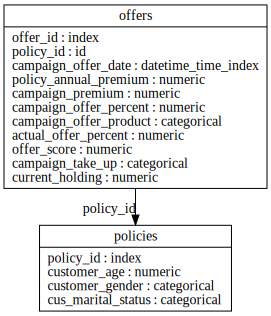

In [8]:
entities = {
       "policies" : (pol_df, "policy_id"),
       "offers" : (offer_df, "offer_id", "campaign_offer_date"),
    }

relationships = [("policies", "policy_id", "offers", "policy_id")]

ft.EntitySet("my-entity-set", entities, relationships).plot()

In [9]:
es = ft.EntitySet("my-entity-set", entities, relationships)
es["offers"]["campaign_take_up"].interesting_values = ["Y", "N"]
es["offers"]["campaign_offer_product"].interesting_values = ["E1", "A1", "A2", "C1","H1","H2"]

In [ ]:
start_time = time.time()

feature_matrix_policy, features_defs = ft.dfs(entities=es,  entityset=es,
                         agg_primitives=['max','median','trend','avg_time_between',\
                                         'min','std','mean','sum','skew',\
                                         'count','mode','last','time_since_first'
                                                                    ],
                        where_primitives=['max','median','trend','avg_time_between',\
                                         'min','std','mean','sum','skew',\
                                         'count','mode','last','time_since_first'
                                                                    ],
                                                 
                                         ignore_variables={'offers': ["offer_id"]},
                                                     target_entity="policies"
                                        )
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
#feature_matrix_policy is compressed as feature_matrix_policy.csv.zip in data directory
feature_matrix_policy.to_csv('data/feature_matrix_policy.csv',index= False)

In [10]:
feature_matrix_policy = pd.read_csv('data/feature_matrix_policy.csv')

/Users/thanatchonchongmankhong/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (476,568) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
len(feature_matrix_policy.columns)
for each in feature_matrix_policy.columns:
    print(each)

604

policy_id
customer_age
customer_gender
cus_marital_status
MAX(offers.offer_score)
MAX(offers.policy_annual_premium)
MAX(offers.current_holding)
MAX(offers.campaign_premium)
MAX(offers.actual_offer_percent)
MAX(offers.campaign_offer_percent)
MEDIAN(offers.offer_score)
MEDIAN(offers.policy_annual_premium)
MEDIAN(offers.current_holding)
MEDIAN(offers.campaign_premium)
MEDIAN(offers.actual_offer_percent)
MEDIAN(offers.campaign_offer_percent)
TREND(offers.policy_annual_premium, campaign_offer_date)
TREND(offers.current_holding, campaign_offer_date)
TREND(offers.campaign_offer_percent, campaign_offer_date)
TREND(offers.campaign_premium, campaign_offer_date)
TREND(offers.actual_offer_percent, campaign_offer_date)
TREND(offers.offer_score, campaign_offer_date)
AVG_TIME_BETWEEN(offers.campaign_offer_date)
MIN(offers.offer_score)
MIN(offers.policy_annual_premium)
MIN(offers.current_holding)
MIN(offers.campaign_premium)
MIN(offers.actual_offer_percent)
MIN(offers.campaign_offer_percent)
STD(offer